## Creating AVW from Rhos
## Let's go get some data first

In [1]:
import earthaccess
import xarray as xr
auth = earthaccess.login()
if not auth.authenticated:
    auth.login(strategy="interactive", persist=True)

Note, just to get a feel for the differences in data handling, let's explore a standard mapped **Level-3** file instead of the individual satellite scene (*Level-2*) that we explored in the $R_{rs} $ tutorial. There are small differences that will make you want to bang your head agaisnt the wall if you're not familiar with them. I have banged my head for you, and now I share what has been learned:

In [2]:
# This gives the shortnames for all of the PACE datasets
#results = earthaccess.search_datasets(instrument="oci")
#for item in results:
#    summary = item.summary()
#    print(summary["short-name"])

In [3]:
#(west, south, east, north)
bbox = (-76.903, 37.873, -75.608, 39.659)
import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L2_SFREFL",
    temporal = ("2025-07-22", "2025-07-22"),
    bounding_box = bbox
)
fileset = earthaccess.open(results);

print(fileset)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250722T173005.L2.SFREFL.V3_1.nc>]


A few key differences to note:

> - short_name: Product based (e.g. RRS, CHL) in Level-3, not the product suite (e.g., AOP, BGC) like in Level-2.
> - bounding_box: Not necessary at this stage, as Level-3 files are inherently global
> - granule_name: *.YR.*,*.MO.*,*.8D.*,*.DAY.* for time; *.0p1deg.*, *.9KM.*, *.4KM.* for spatial

Alright, let's open this up! Libraries first!

In [4]:
# Load Libraries 
import numpy as np
import xarray as xr
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.integrate import trapezoid

In [5]:
# open_datatree is for netcdf files with groups
datatree = xr.open_datatree(fileset[0], decode_timedelta=False)
datatree.groups

('/',
 '/sensor_band_parameters',
 '/scan_line_attributes',
 '/geophysical_data',
 '/navigation_data',
 '/processing_control',
 '/processing_control/input_parameters',
 '/processing_control/flag_percentages')

In [6]:
# We merge the groups all together so we have the lat/lon and 
# This works due to the values in each group have the same shape.
ds = xr.merge(datatree.to_dict().values())
ds = ds.set_coords(("longitude", "latitude"))
ds["number_of_lines"] = ds["number_of_lines"]
ds["pixels_per_line"] = ds["pixels_per_line"]
ds = ds.set_xindex(("longitude", "latitude"), xr.indexes.NDPointIndex)
ds

<xarray.Dataset> Size: 1GB
Dimensions:          (number_of_bands: 286, number_of_reflective_bands: 286,
                      wavelength_3d: 122, number_of_lines: 1710,
                      pixels_per_line: 1272)
Coordinates:
  * wavelength_3d    (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
  * number_of_lines  (number_of_lines) int64 14kB 0 1 2 3 ... 1707 1708 1709
  * pixels_per_line  (pixels_per_line) int64 10kB 0 1 2 3 ... 1269 1270 1271
  * longitude        (number_of_lines, pixels_per_line) float32 9MB -84.64 .....
  * latitude         (number_of_lines, pixels_per_line) float32 9MB 22.58 ......
Dimensions without coordinates: number_of_bands, number_of_reflective_bands
Data variables: (12/25)
    wavelength       (number_of_bands) float64 2kB ...
    vcal_gain        (number_of_reflective_bands) float32 1kB ...
    vcal_offset      (number_of_reflective_bands) float32 1kB ...
    F0               (number_of_reflective_bands) float32 1kB ...
    aw               (number_of_reflective_bands) float32 1kB ...
    bbw              (number_of_reflective_bands) float32 1kB ...
    ...               ...
    clat             (number_of_lines) float32 7kB ...
    elat             (number_of_lines) float32 7kB ...
    csol_z           (number_of_lines) float32 7kB ...
    rhos             (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB ...
    l2_flags         (number_of_lines, pixels_per_line) int32 9MB ...
    tilt             (number_of_lines) float32 7kB ...
Indexes:
  ┌ longitude  NDPointIndex (ScipyKDTreeAdapter)
  └ latitude
Attributes: (12/47)
    title:                             OCI Level-2 Data SFREFL
    product_name:                      PACE_OCI.20250722T173005.L2.SFREFL.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data2/sdpsoper/vdc/vpu21/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -92.374756
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9688000679016113
    geospatial_bounds:                 POLYGON ((-59.96334 45.67412, -92.3747...

In [7]:
# Extract hyperspectral Rhos
rhos_array = ds['rhos'] # shape: (wavelength, lat, lon), squaring Rhos for to expand range of AVW
squared_rhos_array = rhos_array ** 2
wavelength = rhos_array['wavelength_3d'].values  # should be in nm

## Subsetting

To make things more efficient, let's subset a region of interest around U.S. side of the North Atlantic ocean.

In [8]:
# Spatial Subset (optional)-76.903, 37.873, -75.608, 39.659
sw = ds.sel(longitude=bbox[0], latitude=bbox[1], method="nearest")
ne = ds.sel(longitude=bbox[2], latitude=bbox[3], method="nearest")
lat_bounds = slice(
    sw["number_of_lines"].item(),
    ne["number_of_lines"].item(),
)
lon_bounds = slice(
    sw["pixels_per_line"].item(),
    ne["pixels_per_line"].item(),
)
rhos_subset = squared_rhos_array.isel(number_of_lines=lat_bounds, pixels_per_line=lon_bounds)
rhos_subset

<xarray.DataArray 'rhos' (number_of_lines: 137, pixels_per_line: 135,
                          wavelength_3d: 122)> Size: 9MB
array([[[6.55183755e-03, 5.62274223e-03, 5.19701326e-03, ...,
         1.82610881e-02, 3.41477129e-03, 3.37080634e-03],
        [5.01659466e-03, 4.51101642e-03, 4.04803269e-03, ...,
         2.39502024e-02, 3.89770325e-03, 4.05787211e-03],
        [5.10328775e-03, 4.36661905e-03, 3.91171593e-03, ...,
         2.21262667e-02, 3.52999242e-03, 3.75867868e-03],
        ...,
        [3.42346472e-03, 3.01271165e-03, 2.78666546e-03, ...,
         4.13431299e-05, 1.73556109e-05, 1.52256998e-05],
        [3.11457482e-03, 2.82468554e-03, 2.61467323e-03, ...,
         1.35040114e-04, 5.39469765e-05, 5.41192276e-05],
        [2.79189693e-03, 2.70517031e-03, 2.47142650e-03, ...,
         1.59014890e-04, 5.33444545e-05, 4.48780665e-05]],

       [[1.82237346e-02, 1.73718594e-02, 1.60461925e-02, ...,
         5.63824177e-02, 2.04898659e-02, 2.03280207e-02],
        [5.41312341e-03, 4.78854869e-03, 4.34861798e-03, ...,
         3.29534374e-02, 6.68172818e-03, 6.76956726e-03],
        [5.51742222e-03, 4.94821230e-03, 4.47487738e-03, ...,
         3.87662165e-02, 8.68612621e-03, 8.54323525e-03],
...
         1.92230627e-01, 1.24493189e-01, 1.32083014e-01],
        [1.93760972e-02, 1.78569984e-02, 1.70244332e-02, ...,
         5.68907447e-02, 2.36828700e-02, 2.18131766e-02],
        [1.27590047e-02, 1.15762474e-02, 1.07529089e-02, ...,
         6.11258149e-02, 1.99702103e-02, 1.82155836e-02]],

       [[5.68436943e-02, 5.58909439e-02, 5.52212186e-02, ...,
         9.34584662e-02, 4.48226668e-02, 4.68195640e-02],
        [1.45283202e-02, 1.31547870e-02, 1.22195389e-02, ...,
         4.17729169e-02, 1.30353142e-02, 1.22250570e-02],
        [1.31856743e-02, 1.18052447e-02, 1.09995762e-02, ...,
         5.22854701e-02, 1.42169185e-02, 1.36585366e-02],
        ...,
        [8.01558271e-02, 7.90721625e-02, 7.40584880e-02, ...,
         1.34685397e-01, 7.38804787e-02, 7.63108209e-02],
        [2.12898348e-02, 1.97134633e-02, 1.93933286e-02, ...,
         6.97422549e-02, 2.88365036e-02, 2.54966393e-02],
        [3.54098380e-02, 3.37675475e-02, 3.48713137e-02, ...,
         9.00767893e-02, 3.92533392e-02, 3.82237695e-02]]],
      shape=(137, 135, 122), dtype=float32)
Coordinates:
  * number_of_lines  (number_of_lines) int64 1kB 1220 1221 1222 ... 1355 1356
  * pixels_per_line  (pixels_per_line) int64 1kB 500 501 502 503 ... 632 633 634
  * wavelength_3d    (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    longitude        (number_of_lines, pixels_per_line) float32 74kB -76.9 .....
    latitude         (number_of_lines, pixels_per_line) float32 74kB 37.87 .....
Attributes:
    long_name:  Surface reflectance
    valid_min:  -0.05
    valid_max:  1.5

In [9]:
#rhos_subset.sel(wavelength_3d=443.0, method="nearest").plot.imshow()

In [10]:
# do AVW calculation using rhos_subset
# Subset wavelengths
rhos_subset_range = rhos_subset.sel(wavelength_3d=slice(400, 700))

# Compute AVW: sum(Rrs) / sum(Rrs / wavelength)
avw = rhos_subset_range.sum(dim='wavelength_3d') / (rhos_subset_range / rhos_subset_range['wavelength_3d']).sum(dim='wavelength_3d')
brightness = rhos_subset_range.integrate(coord='wavelength_3d').compute()


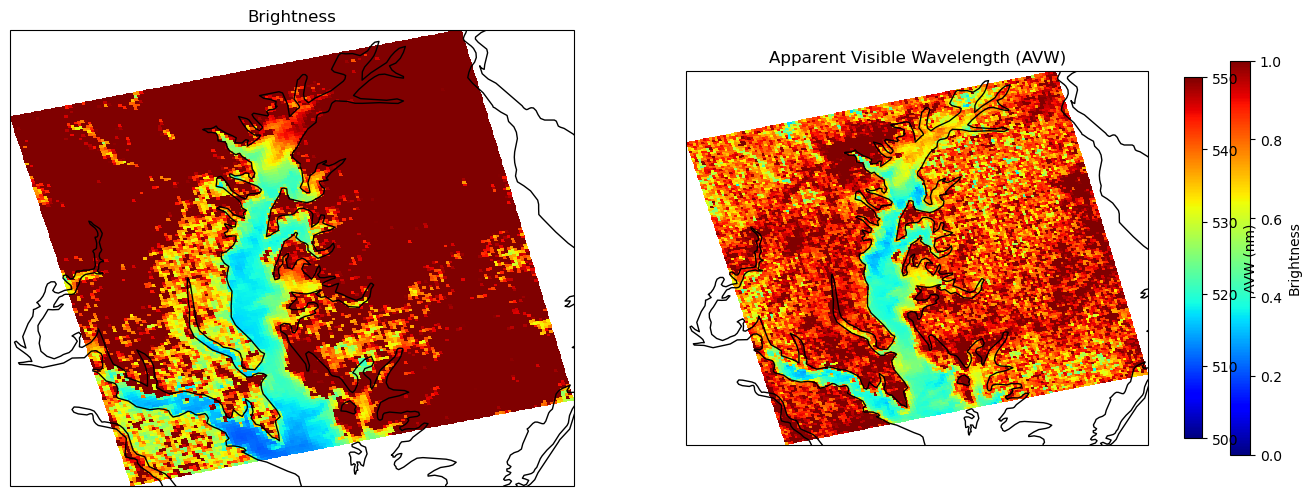

In [12]:
# User-defined AVW range, brightness
avw_min = 500
avw_max = 550
b_min = 0
b_max = 1.0


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), subplot_kw={'projection': ccrs.PlateCarree()})
#fig, (ax2) = plt.subplots(1, figsize=(16, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# Class map
colors = plt.cm.jet(np.linspace(0, 1, 23))
cmap_classes = ListedColormap(colors)
boundaries = np.arange(1, 25)  # 23 classes → 24 boundaries
norm_classes = BoundaryNorm(boundaries, ncolors=23, clip=True)

# Brightness map
c1 = ax1.pcolormesh(brightness.longitude, brightness.latitude, brightness, vmin=b_min, vmax=b_max, cmap='jet', shading='auto')
ax1.coastlines()
ax1.set_title('Brightness')
cbar1 = plt.colorbar(c1, ax=ax2, fraction=0.035, pad=.05)
cbar1.set_label('Brightness')

# AVW map
c2 = ax2.pcolormesh(avw.longitude, avw.latitude, avw, cmap='jet', vmin=avw_min, vmax=avw_max, shading='auto')
ax2.coastlines()
ax2.set_title('Apparent Visible Wavelength (AVW)')
cbar2 = plt.colorbar(c2, ax=ax2, fraction=0.035, pad=0.07)
cbar2.set_label('AVW (nm)')

plt.show()




In [ ]:
fig.savefig("AVW_brightness_rhos_Aug272024_Heterocapsa.png",dpi=300,bbox_inches="tight")
